![alt text](https://raw.githubusercontent.com/dsloet/StyleTransfer/master/style_transfered.png)

Hackathon Friday 10th of January 2020.

#Style Transfer 

In this hackathon we will prepare ourselves to get a little bit up to speed with the upcoming project based hackathon. In the following project based hackathon will we build an online service that will allow visitors to do a style transfer by themselves without the need of code.

This hackathon is used to familiarise ourselves with some of the key features that allow us to perform a style transfer.

The image above shows how we can transfer the style of picasso onto a sketch of a ballerina using this notebook. We will code some of the base functions that makes this possible and by doing this ourselves we will learn how some linear algebra in combination with the pretrained model VGG19 can yield some exquisit results.

In case you wish to jump straight to style transfering your own images: working code is published on the github as well. It is also possible to do hyperparameter tuning to get a desired result even quicker.

In [1]:
# Load all necessary packages
%tensorflow_version 1x
from IPython.display import Image
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image

# Keras is only used to load VGG19 model as a high level API to TensorFlow 
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import backend as K

# pillow is used for loading and saving images
from PIL import Image

# numPy is used for manipulation of array of object i.e Image in our case
import numpy as np

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
!git clone https://github.com/dsloet/StyleTransfer.git

Cloning into 'StyleTransfer'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 41), reused 54 (delta 20), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [3]:
%cd StyleTransfer/

/content/StyleTransfer


In [0]:
# Create a folder to store created images.
%mkdir style_tensorflow/output_images

In [5]:
# Download pretrained weights for VGG19 model.
import urllib.request
urllib.request.urlretrieve('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x7f36308ef550>)

In [0]:
# Load custom modules
from style_tensorflow.StyleTransferTF import get_feature_representations # use these only if you want to run the model #, get_content_loss, gram_matrix, get_style_loss
from style_tensorflow.StyleTransferTF import compute_loss
from style_tensorflow.utils_tf import load_img, deprocess_img

**Problem — 1. Generate Content:** The problem is to produce an image that contains a content as in the content image.

_One point to note here is that the image should only contain the content(as in a rough sketch of the content image and not the texture from it, since the output should contain a style as that of the style image)_

**Solution:** The answer should be pretty straightforward. Use MSE loss(or any similarity measure such as SSIM, PSNR) between input and the target. But what is the target here? Well, if there were no constraints on the style of the output, then simply MSE between input and content image would be sufficient. So how to get an image’s content without copying its style?

Use feature maps.

Convolutional feature maps are generally a very good representation of input image’s features. They capture spatial information of an image without containing the style information(if a feature map is used as it is), which is what we need. And this is the reason we keep the backbone weights fixed during backpropagation.

Therefore, MSE loss between the input image’s features and content image’s features will work!


![content loss](https://miro.medium.com/max/468/1*PKnjB3bxzgg6yy0uOsljqw.png)

Let's build this equation first. It's called get_content_loss.

In [0]:
def get_content_loss(content_image, target_image):
  """
  Compute the content loss for style transfer.
    Inputs:
    - base: features of the content image, Tensor with shape [height, width, channels]
    - output: features of the generated image, Tensor with shape[H,W,C]

    Returns:
    - Scalar of content loss

  Your code goes here
  """
  

**Problem — 2. Generate Style:**
The problem is to produce an image which contains the style as in the style image.

Solution: To extract the style of an image(or more specifically to compute the style loss), we need something called as Gram matrix. The gram matrix uses the dot product because the dot can be seen as a way of measuring the similarity between two vectors.

We use the feature map F as a flattenend vector and multiply it with itself. This will then tell something about its style and not its structure since we flattenend the features already.

This will generate a C x C matrix which we call the gram matrix.

![Gram Matrix](https://miro.medium.com/max/259/1*C3fkQanKHMwOi_rf0q0OQQ.png)

Instead of the dot product, we want the Gram matrix. The equation is given above.

In [0]:
def gram_matrix(input_tensor):
  """
  Computes the outer-product of the input tensor x.

    Input:
    - x: input tensor of shape [H,W,C]. We reshape it to [C (H, W)]

    Returns:
    Tensor of shape [C,C] corresponding to the Gram matrix
  
  
  """
  # if input tensor is a 3D array of size Nh x Nw X Nc
  # we reshape it to a 2D array of Nc x (Nh*Nw)
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])

  # Now define your gram matrix below:


The gram matrix is then used to calculate the style loss. The style loss is calculated using:

![alt text](https://miro.medium.com/max/373/1*0nASi-BjZI3I9J0RWo7wtw.png)

In [0]:
def get_style_loss(base_style, gram_target):

  """
  Computes the style reconstruction loss.

  Inputs:
  - base: features at given layer of the style image.
  - output: features of the generated image.

  Returns:
  - style_loss: scalar style loss
    
  Your code goes here
  """


Below the function get_model.

Something we should consider is that we are going to use the pretrained model VGG19. This model is loaded and then we say to each layer that we don't want to train this model. we only want to change the content image so that the style of the style images is transfered to the content image.

In [0]:
# Using Keras Load VGG19 model
def get_model(content_layers,style_layers):

  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg19           = VGG19(weights=None, include_top=False)

  # We don't need to (or want to) train any layers of our pre-trained vgg model, so we set it's trainable to false.
  vgg19.trainable = False

  style_model_outputs   =  [vgg19.get_layer(name).output for name in style_layers]
  content_model_outputs =  [vgg19.get_layer(name).output for name in content_layers]
  
  model_outputs = content_model_outputs + style_model_outputs

  # Build model 
  return Model(inputs = vgg19.input, outputs = model_outputs),  vgg19

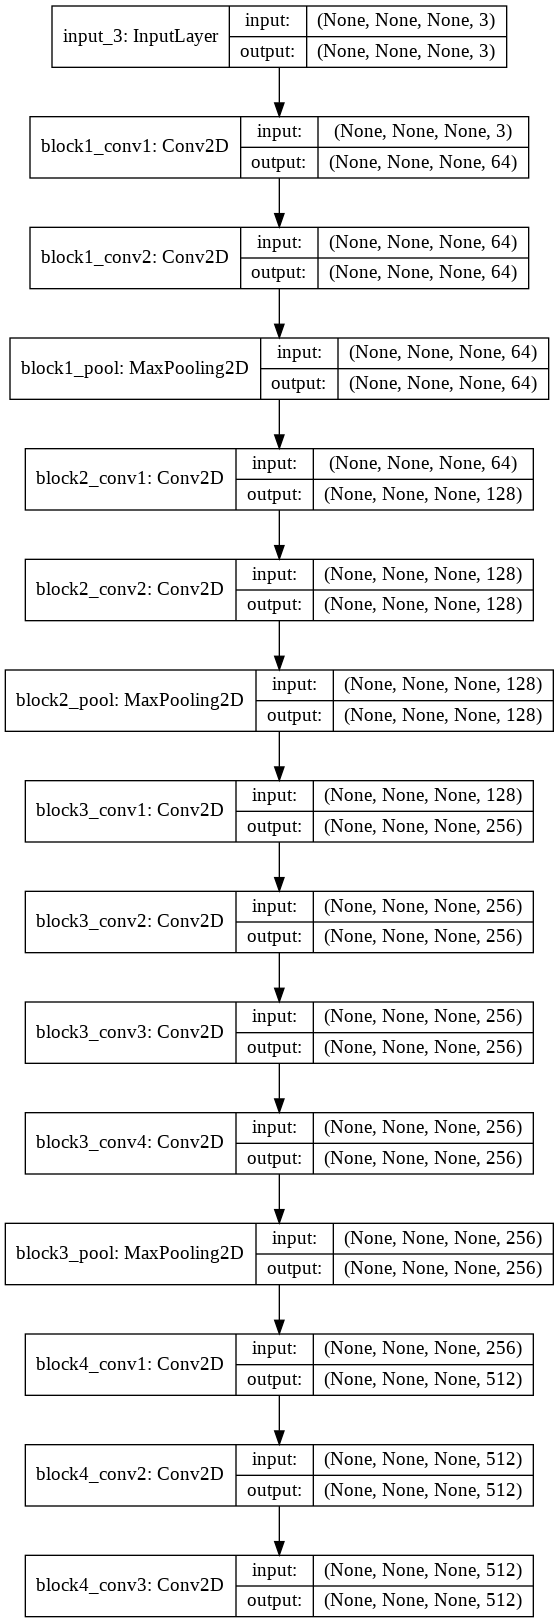

In [17]:
# Show the VGG model:
vgg_model, vgg19 = get_model(content_layers = ['block3_conv3'], style_layers   = ['block1_conv1','block2_conv2','block4_conv3'])
from keras.utils.vis_utils import plot_model
plot_model(vgg_model,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

The next function is where all the magic comes together.

In [0]:
def run_style_transfer(content_path, style_path, num_iterations=200, content_weight=0.1, style_weight=0.9): 

  # Create a tensorflow session 
  sess = tf.Session()

  # Assign keras back-end to the TF session which we created
  K.set_session(sess)

  model, vgg19 = get_model(content_layers,style_layers)

  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path, num_content_layers)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # VGG default normalization
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means 
    

  # In original paper, the initial stylized image is random matrix of same size as that of content image
  # but in later images content image was used instead on random values for first stylized image
  # because it proved to help to stylize faster
  generated_image = load_img(content_path)
  # generated_image = np.random.randint(0,255, size=generated_image.shape) 
  
  # Create tensorflow variable to hold a stylized/generated image during the training 
  generated_image = tf.Variable(generated_image, dtype=tf.float32)

  model_outputs = model(generated_image)

  # weightages of each content and style images i.e alpha & beta
  loss_weights = (style_weight, content_weight)

  # Create our optimizer
  loss = compute_loss(model, loss_weights, model_outputs, gram_style_features, content_features, num_content_layers, num_style_layers)
  opt = tf.train.AdamOptimizer(learning_rate=9, beta1=0.9, epsilon=1e-1).minimize( loss[0], var_list = [generated_image])

  sess.run(tf.global_variables_initializer())
  sess.run(generated_image.initializer)
  
  # loading the weights again because tf.global_variables_initializer() resets the weights
  vgg19.load_weights(vgg_weights)


  # Put loss as infinity before training starts and Create a variable to hold best image (i.e image with minimum loss)
  best_loss, best_img = float('inf'), None

  for i in range(num_iterations):

    # Do optimization
    sess.run(opt)

    # Make sure image values stays in the range of max-min value of VGG norm 
    clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
    # assign the clipped value to the tensor stylized image
    generated_image.assign(clipped)


    # Open the Tuple of tensors 
    total_loss, style_score, content_score = loss
    total_loss = total_loss.eval(session=sess)


    if total_loss < best_loss:

      # Update best loss and best image from total loss. 
      best_loss = total_loss

      # generated image is of shape (1, h, w, 3) convert it to (h, w, 3)
      temp_generated_image = sess.run(generated_image)[0]
      best_img = deprocess_img(temp_generated_image)

      s_loss = sess.run(style_score)
      c_loss = sess.run(content_score)

      # print best loss
      print('best: iteration: ', i ,'loss: ', total_loss ,'  style_loss: ',  s_loss,'  content_loss: ', c_loss)

    # Save image after every 100 iterations 
    if (i+1)%10 == 0:
      output = Image.fromarray(best_img)
      output.save('style_tensorflow/output_images/'+str(i+1)+'-'+save_name)

  # after num_iterations iterations are completed, close the TF session 
  sess.close()
      
  return best_img, best_loss

Settings before we hit the training session.

In [0]:
# list of layers to be considered for calculation of Content and Style Loss
content_layers = ['block3_conv3']
style_layers   = ['block1_conv1','block2_conv2','block4_conv3']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

# path where the content and style images are located
content_path = 'images/dancing.jpg'
style_path   = 'images/picasso.jpg'

# Save the result as
save_name = 'dance_picasso.jpg'

# path to where Vgg19 model weight is located 
vgg_weights = "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5" 

In [16]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=100, content_weight=0.1)




best: iteration:  0 loss:  35113508.0   style_loss:  39013160.0   content_loss:  16622.217
best: iteration:  1 loss:  31993568.0   style_loss:  35546336.0   content_loss:  18658.662
best: iteration:  2 loss:  21476968.0   style_loss:  23861404.0   content_loss:  17031.717
best: iteration:  3 loss:  16614872.0   style_loss:  18459154.0   content_loss:  16323.75
best: iteration:  4 loss:  13318342.0   style_loss:  14796218.0   content_loss:  17456.79
best: iteration:  5 loss:  10285835.0   style_loss:  11426650.0   content_loss:  18504.896
best: iteration:  6 loss:  8041299.0   style_loss:  8932690.0   content_loss:  18781.469
best: iteration:  7 loss:  6631779.5   style_loss:  7366506.0   content_loss:  19243.584
best: iteration:  8 loss:  4929817.0   style_loss:  5475372.0   content_loss:  19823.104
best: iteration:  9 loss:  3906301.0   style_loss:  4338065.0   content_loss:  20425.188
best: iteration:  10 loss:  3079168.5   style_loss:  3418984.2   content_loss:  20828.86
best: it